# Applying Causal Inference techniques to identify effective COVID-19 policies on time varying data

## Installing the Causality and other mathematical packages

In [1]:
# Install a pip package in the current Jupyter kernel
import sys
!pip install causality

!pip install pandas
!pip install decorator>=4.1.2
!pip install networkx>=2.0
!pip install numpy>=1.13.3
!pip install pandas>=0.20.3
!pip install patsy>=0.4.1
!pip install python-dateutil>=2.6.1
!pip install pytz>=2017.2
!pip install scipy>=0.19.1
!pip install six>=1.11.0
!pip install statsmodels>=0.8.0

!pip install networkx
!pip install matplotlib

# IC Algorithm Tutorial: https://pypi.org/project/causality/
import numpy
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import duckdb

from causality.inference.search import IC
from causality.inference.independence_tests import RobustRegressionTest
print('causality packages imported successfully')

causality packages imported successfully


## Data Pre-processing

### Mount the Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Convert the outcomes matrix (Cases/Deaths) into the proper time series format


In [3]:
death_matrix = pd.read_csv("drive/MyDrive/CausalAI/confirm_death_matrix_new.csv")

death_matrix.rename(columns={'0': 'county'}, inplace=True)

death_matrix = death_matrix.drop(death_matrix.columns[0], axis=1)


melted_df = pd.melt(death_matrix, id_vars=['county'], var_name='version', value_name='value')

# Extract the version number from the 'version' column
melted_df['version'] = melted_df['version'].str.slice(0, 9).astype('object')

# Sort the DataFrame by 'id' and 'version'
melted_df.sort_values(by=['county', 'version'], inplace=True)

# Reset the index if needed
melted_df.reset_index(drop=True, inplace=True)



# Connect to DuckDB (make sure to have DuckDB installed: pip install duckdb)
con = duckdb.connect(database=':memory:')

# Create a DuckDB table from the DataFrame
con.register('death_mtx', melted_df)

# Query the DuckDB table
result = con.execute("SELECT county, SUBSTRING(CONCAT(version, '.') FROM 1 FOR POSITION('.' IN CONCAT(version, '.')) - 1) as date, max(case when version not like '%.%' then value else 0 end) as cases, max(case when version like '%.%' then value else 0 end) as deaths  FROM death_mtx group by 1,2").fetchdf()


result.reset_index(drop=True, inplace=True)

result[['county', 'state']] = result['county'].str.split(',', expand=True)


# Display the result
result

,county,date,cases,deaths,state
0,Howell,3/2/20,0,0,MO
1,Howell,3/21/20,0,0,MO
2,Howell,3/22/20,0,0,MO
3,Howell,3/24/20,0,0,MO
4,Howell,3/25/20,0,0,MO
...,...,...,...,...,...
134890,Yuma,9/3/20,12269,325,AZ
134891,Yuma,9/4/20,12297,326,AZ
134892,Yuma,9/5/20,12311,330,AZ
134893,Yuma,9/8/20,12340,331,AZ


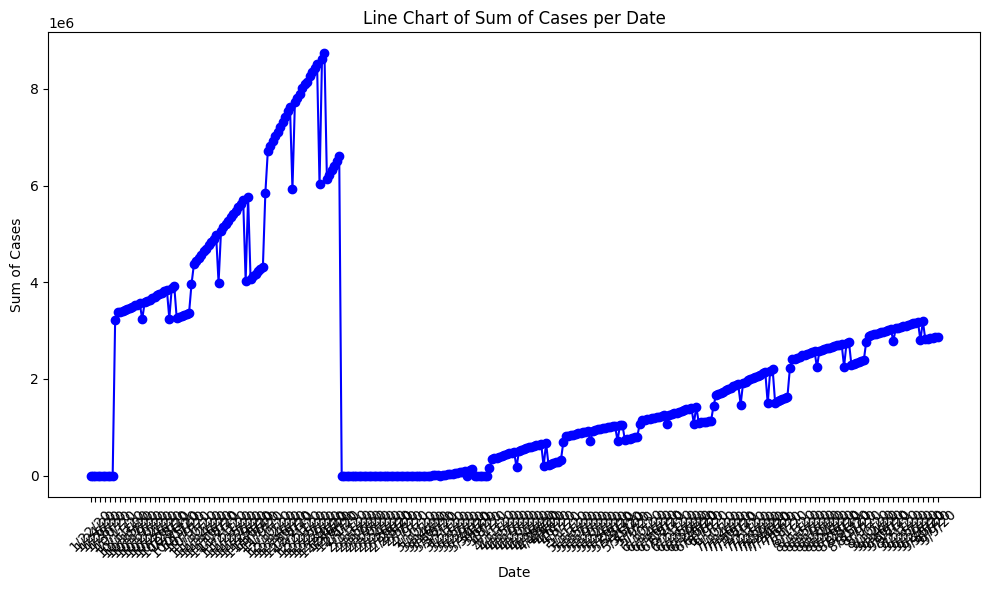

In [7]:
cases_per_date = result.groupby('date')['cases'].sum()


# Plotting the line chart
plt.figure(figsize=(10, 6))
plt.plot(cases_per_date.index, cases_per_date, marker='o', linestyle='-', color='b')

# Formatting the plot
plt.title('Line Chart of Sum of Cases per Date')
plt.xlabel('Date')
plt.ylabel('Sum of Cases')
plt.xticks(rotation=45)

# Display only every Nth date on the x-axis (adjust 'N' based on your preference)
N = 2
plt.xticks(cases_per_date.index[::N], rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

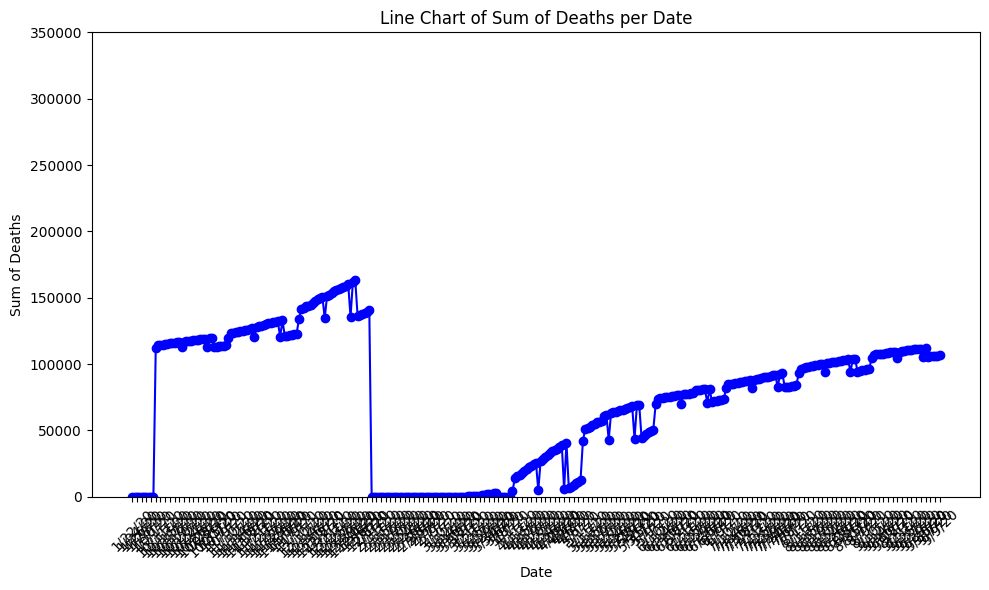

In [5]:
deaths_per_date = result.groupby('date')['deaths'].sum()


# Plotting the line chart
plt.figure(figsize=(10, 6))
plt.plot(deaths_per_date.index, deaths_per_date, marker='o', linestyle='-', color='b')

# Formatting the plot
plt.title('Line Chart of Sum of Deaths per Date')
plt.xlabel('Date')
plt.ylabel('Sum of Deaths')
plt.xticks(rotation=45)

# Display only every Nth date on the x-axis (adjust 'N' based on your preference)
N = 2
plt.xticks(deaths_per_date.index[::N], rotation=45)

plt.ylim(0, 350000)


# Show the plot
plt.tight_layout()
plt.show()

### Adding state and county policies to the time series data as binary variables setting on the start date and unsetting on the end date

In [11]:
state_policy = pd.read_csv("/content/drive/MyDrive/CausalAI/state_policy_updates_20201206_0721.csv")

con = duckdb.connect(database=':memory:')

# Create a DuckDB table from the DataFrame
con.register('state_policy', state_policy)

# Query the state DuckDB table
statep = con.execute("SELECT state_id, case when policy_type like '%Mask%' then 'Mask Mandate' when policy_type like 'travel' then 'Travel' else policy_type end as policy_type, max(case when start_stop = 'start' then date else '' end) as start_date, max(case when start_stop = 'stop' then date else '' end) as stop_date from state_policy where policy_level = 'state' group by 1,2").fetchdf()


statep.reset_index(drop=True, inplace=True)

statep.rename(columns={'state_id': 'state'}, inplace=True)


statep.to_csv('/content/drive/MyDrive/CausalAI/statep.csv', index=False)




# Query the county DuckDB table
countyp = con.execute("SELECT REPLACE(county, ' County', '') as county, state_id, case when policy_type like '%Mask%' then 'Mask Mandate' when policy_type like 'travel' then 'Travel' else policy_type end as policy_type, max(case when start_stop = 'start' then date else '' end) as start_date, max(case when start_stop = 'stop' then date else '' end) as stop_date from state_policy where policy_level = 'county' group by 1,2,3").fetchdf()


countyp.reset_index(drop=True, inplace=True)

countyp.rename(columns={'state_id': 'state'}, inplace=True)


countyp.to_csv('/content/drive/MyDrive/CausalAI/countyp.csv', index=False)





con = duckdb.connect(database=':memory:')

# Create a DuckDB table from the DataFrame
con.register('statep', statep)

con.register('countyp', countyp)

con.register('result', result)



# Query the DuckDB table
mergeddf = con.execute("SELECT r.county, r.state, r.date, r.cases, r.deaths, coalesce(s.policy_type, c.policy_type, '') as policy_type from result r left join statep s on r.state = s.state and (r.date > s.start_date or s.start_date is null or s.start_date = '') and (r.date < s.stop_date or s.stop_date is null or s.stop_date = '') left join countyp c on r.state = c.state and r.county = c.county and (r.date > s.start_date or s.start_date is null or s.start_date = '') and (r.date < s.stop_date or s.stop_date is null or s.stop_date = '')").fetchdf()


mergeddf = mergeddf.pivot_table(index=['county', 'state', 'date', 'cases', 'deaths'], columns='policy_type', aggfunc='size', fill_value=0).reset_index()


mergeddf = mergeddf.reset_index()

mergeddf = mergeddf.drop(mergeddf.columns[0], axis=1)


final_features = mergeddf.drop(['county', 'state'], axis=1)

final_features = final_features.fillna(0)

# final_features = final_features.apply(pd.to_numeric, errors='coerce')

final_features



policy_type,date,cases,deaths,,Agriculture,Allow Audio Only Telehealth,Allow Expand Medicaid Telehealth Coverage,Alternative Care Facilities,Childcare (K-12),Colleges & Universities,...,State of Emergency/Funds,Stop Enforcement Of Evictions Overall Or Due To Covid Related Issues,Stop Initiation Of Evictions Overall Or Due To Covid Related Issues,Suspended Elective Medical Dental Procedures,Travel,Updated Guidelines,Wholesale Trade,higher education,libraries,training jobs
0,1/22/20,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1/23/20,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1/24/20,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1/25/20,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1/26/20,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134890,9/5/20,12311,330,0,0,1,1,0,1,0,...,0,1,0,1,0,0,0,0,0,0
134891,9/6/20,12325,331,0,0,1,1,0,1,0,...,0,1,0,1,0,0,0,0,0,0
134892,9/7/20,12333,331,0,0,1,1,0,1,0,...,0,1,0,1,0,0,0,0,0,0
134893,9/8/20,12340,331,0,0,1,1,0,1,0,...,0,1,0,1,0,0,0,0,0,0


### Creating the column dictionary to be fed to the IC algorithm model

In [12]:
columns_list = []
number_of_columns = 0

def columns_to_list(data_df):
    # Save headers/column names to a list
    columns_list = list(data_df.columns)

    return columns_list

def column_length(columns_list):
    # Save the number of columns/headers present in the dataset
    number_of_columns = len(columns_list)
    print(number_of_columns)

    return number_of_columns


columns_list_covid = columns_to_list(final_features)
number_of_columns_covid = column_length(columns_list_covid)

c_list = []

def c_list_maker(n):
    c_list = ['c'] * n
    return c_list

c_value = c_list_maker(number_of_columns_covid)

# Merge headers list and type of variable list
final_list = []

def column_value(columns_list, c_value):
    final_list = []
    for (item1, item2) in zip(columns_list, c_value):
        final_list.append(item1)
        final_list.append(item2)
    return final_list

final_list_covid = column_value(columns_list_covid, c_value)


header_dct = {}

# Convert list to dictionary
def convert_list_to_dict(final_list):
    header_dct = {final_list[i]: final_list[1] for i in range(0, len(final_list), 2)}
    return header_dct

header_dct_covid = convert_list_to_dict(final_list_covid)
# Check if converted correctly
print(header_dct_covid)

60
{'date': 'c', 'cases': 'c', 'deaths': 'c', '': 'c', 'Agriculture': 'c', 'Allow Audio Only Telehealth': 'c', 'Allow Expand Medicaid Telehealth Coverage': 'c', 'Alternative Care Facilities ': 'c', 'Childcare (K-12)': 'c', 'Colleges & Universities': 'c', 'Construction': 'c', 'Day Care': 'c', 'Day camps/overnight camps': 'c', 'Education': 'c', 'Election': 'c', 'Entertainment': 'c', 'Executive Order': 'c', 'Food and Drink': 'c', 'Froze Mortgage Payments': 'c', 'Gatherings': 'c', 'Graduation': 'c', 'Graduation Ceremony guidelines': 'c', 'Gyms': 'c', 'Health Risk Status': 'c', 'Houses of Worship': 'c', 'Manufacturing': 'c', 'Mask Mandate': 'c', 'Medical': 'c', 'Modify Medicaid Requirements With 1135 Waivers Date Of CMS Approval': 'c', 'New Phase': 'c', 'Non-Essential Businesses': 'c', 'Nursing Home Visitations': 'c', 'Nursing Homes': 'c', 'Order Freezing Utility Shut Offs': 'c', 'Outdoor and Recreation': 'c', 'Personal Care': 'c', 'Phase 1': 'c', 'Phase 2': 'c', 'Phase 3': 'c', 'Phase 3 St

In [13]:
# from sklearn import preprocessing

# x = final_features.values #returns a numpy array
# min_max_scaler = preprocessing.MinMaxScaler()
# x_scaled = min_max_scaler.fit_transform(x)
# final_features_normalized = pd.DataFrame(x_scaled)

# final_features_normalized.columns = final_features.columns

subset_df = final_features.iloc[:, :10]
subset_header_dct_covid = dict(list(header_dct_covid.items())[:10])


## Building a Causal Dataframe from the cleaned dataframe

In [28]:
import matplotlib.pyplot as pp
from causality.analysis.dataframe import CausalDataFrame

covid_causal_df = CausalDataFrame(final_features)

covid_causal_df
covid_causal_df.columns

Index(['date', 'cases', 'deaths', '', 'Agriculture',
       'Allow Audio Only Telehealth',
       'Allow Expand Medicaid Telehealth Coverage',
       'Alternative Care Facilities ', 'Childcare (K-12)',
       'Colleges & Universities', 'Construction', 'Day Care',
       'Day camps/overnight camps', 'Education', 'Election', 'Entertainment',
       'Executive Order', 'Food and Drink', 'Froze Mortgage Payments',
       'Gatherings', 'Graduation', 'Graduation Ceremony guidelines', 'Gyms',
       'Health Risk Status', 'Houses of Worship', 'Manufacturing',
       'Mask Mandate', 'Medical',
       'Modify Medicaid Requirements With 1135 Waivers Date Of CMS Approval',
       'New Phase', 'Non-Essential Businesses', 'Nursing Home Visitations',
       'Nursing Homes', 'Order Freezing Utility Shut Offs',
       'Outdoor and Recreation', 'Personal Care', 'Phase 1', 'Phase 2',
       'Phase 3', 'Phase 3 Step 2', 'Phase 4', 'Phase 5', 'Public Gatherings',
       'Public Health Advisory System', 'Qua

## IC Algorithm to generate causal graphs for cases and deaths for Social Distancing set of Policies

In [15]:
import numpy
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import time


from causality.inference.search import IC
from causality.inference.independence_tests import RobustRegressionTest

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve, roc_curve, auc, average_precision_score
from sklearn.metrics import confusion_matrix




# Run the IC Search Algorithm
def run_IC(data_df, header_dct):

    # Check time Elapsed for IC Algorithm to run
    # Time in seconds
    start = time.time()

    # run the IC search
    ic_algorithm = IC(RobustRegressionTest)
    graph = ic_algorithm.search(data_df, header_dct)

    end = time.time()
    print(end - start)
    print("IC Algorithm successfully run")
    return graph



cases_dct_covid = {'State of Emergency':'c', 'Childcare (K-12)':'c', 'Nursing Homes':'c', 'Gatherings':'c', 'Food and Drink':'c', 'cases':'c'}
cases_columns = ['State of Emergency', 'Childcare (K-12)', 'Nursing Homes', 'Gatherings', 'Food and Drink', 'cases']

# Filter the DataFrame to include only the selected columns
covid_causal_df['date'] = pd.to_datetime(covid_causal_df['date'])

start_date = '01/01/2020'
end_date = '03/26/2020'
cases_df_Mar26 = covid_causal_df[(covid_causal_df['date'] >= start_date) & (covid_causal_df['date'] <= end_date)][cases_columns]


start_date = '03/26/2020'
end_date = '05/29/2020'
cases_df_May29 = covid_causal_df[(covid_causal_df['date'] >= start_date) & (covid_causal_df['date'] <= end_date)][cases_columns]



start_date = '01/01/2020'
end_date = '08/01/2020'
cases_df_Aug01 = covid_causal_df[(covid_causal_df['date'] >= start_date) & (covid_causal_df['date'] <= end_date)][cases_columns]



start_date = '01/01/2020'
end_date = '10/04/2020'
cases_df_Oct04 = covid_causal_df[(covid_causal_df['date'] >= start_date) & (covid_causal_df['date'] <= end_date)][cases_columns]


start_date = '01/01/2020'
end_date = '12/07/2020'
cases_df_Dec07 = covid_causal_df[(covid_causal_df['date'] >= start_date) & (covid_causal_df['date'] <= end_date)][cases_columns]




deaths_dct_covid = {'State of Emergency':'c', 'Childcare (K-12)':'c', 'Nursing Homes':'c', 'Gatherings':'c', 'Food and Drink':'c', 'deaths':'c'}
deaths_columns = ['State of Emergency', 'Childcare (K-12)', 'Nursing Homes', 'Gatherings', 'Food and Drink', 'deaths']


start_date = '01/01/2020'
end_date = '03/26/2020'
deaths_df_Mar26 = covid_causal_df[(covid_causal_df['date'] >= start_date) & (covid_causal_df['date'] <= end_date)][deaths_columns]


start_date = '01/01/2020'
end_date = '05/29/2020'
deaths_df_May29 = covid_causal_df[(covid_causal_df['date'] >= start_date) & (covid_causal_df['date'] <= end_date)][deaths_columns]



start_date = '01/01/2020'
end_date = '08/01/2020'
deaths_df_Aug01 = covid_causal_df[(covid_causal_df['date'] >= start_date) & (covid_causal_df['date'] <= end_date)][deaths_columns]



start_date = '01/01/2020'
end_date = '10/04/2020'
deaths_df_Oct04 = covid_causal_df[(covid_causal_df['date'] >= start_date) & (covid_causal_df['date'] <= end_date)][deaths_columns]


start_date = '01/01/2020'
end_date = '12/07/2020'
deaths_df_Dec07 = covid_causal_df[(covid_causal_df['date'] >= start_date) & (covid_causal_df['date'] <= end_date)][deaths_columns]

In [17]:
graph_covid_Mar26 = run_IC(cases_df_Mar26, cases_dct_covid)
graph_covid_May29 = run_IC(cases_df_May29, cases_dct_covid)
graph_covid_Aug01 = run_IC(cases_df_Aug01, cases_dct_covid)
graph_covid_Oct04 = run_IC(cases_df_Oct04, cases_dct_covid)
graph_covid_Dec07 = run_IC(cases_df_Dec07, cases_dct_covid)

/usr/local/lib/python3.10/dist-packages/statsmodels/robust/robust_linear_model.py:288: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  warnings.warn('Estimated scale is 0.0 indicating that the most'
/usr/local/lib/python3.10/dist-packages/statsmodels/robust/robust_linear_model.py:288: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  warnings.warn('Estimated scale is 0.0 indicating that the most'
/usr/local/lib/python3.10/dist-packages/statsmodels/robust/robust_linear_model.py:166: RuntimeWarning: invalid value encountered in divide
  return self.M(tmp_resid / tmp_results.scale).sum()
/usr/local/lib/python3.10/dist-packages/statsmodels/robust/robust_linear_model.py:288: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  warnings.warn('Estimated scal

6.6181418895721436
IC Algorithm successfully run


/usr/local/lib/python3.10/dist-packages/statsmodels/robust/robust_linear_model.py:166: RuntimeWarning: invalid value encountered in divide
  return self.M(tmp_resid / tmp_results.scale).sum()
/usr/local/lib/python3.10/dist-packages/statsmodels/robust/robust_linear_model.py:288: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  warnings.warn('Estimated scale is 0.0 indicating that the most'
/usr/local/lib/python3.10/dist-packages/statsmodels/robust/robust_linear_model.py:166: RuntimeWarning: invalid value encountered in divide
  return self.M(tmp_resid / tmp_results.scale).sum()
/usr/local/lib/python3.10/dist-packages/statsmodels/robust/robust_linear_model.py:288: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  warnings.warn('Estimated scale is 0.0 indicating that the most'
/usr/local/lib/python3.10/dist-packages/statsmodels/ro

24.661407470703125
IC Algorithm successfully run


/usr/local/lib/python3.10/dist-packages/statsmodels/robust/robust_linear_model.py:288: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  warnings.warn('Estimated scale is 0.0 indicating that the most'
/usr/local/lib/python3.10/dist-packages/statsmodels/robust/robust_linear_model.py:288: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  warnings.warn('Estimated scale is 0.0 indicating that the most'
/usr/local/lib/python3.10/dist-packages/statsmodels/robust/robust_linear_model.py:288: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  warnings.warn('Estimated scale is 0.0 indicating that the most'
/usr/local/lib/python3.10/dist-packages/statsmodels/robust/robust_linear_model.py:288: ConvergenceWarning: Estimated scale is 0.0 indicating that the most la

186.8662393093109
IC Algorithm successfully run


/usr/local/lib/python3.10/dist-packages/statsmodels/robust/robust_linear_model.py:288: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  warnings.warn('Estimated scale is 0.0 indicating that the most'
/usr/local/lib/python3.10/dist-packages/statsmodels/robust/robust_linear_model.py:288: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  warnings.warn('Estimated scale is 0.0 indicating that the most'
/usr/local/lib/python3.10/dist-packages/statsmodels/robust/robust_linear_model.py:288: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  warnings.warn('Estimated scale is 0.0 indicating that the most'


291.2923605442047
IC Algorithm successfully run


/usr/local/lib/python3.10/dist-packages/statsmodels/robust/robust_linear_model.py:288: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  warnings.warn('Estimated scale is 0.0 indicating that the most'
/usr/local/lib/python3.10/dist-packages/statsmodels/robust/robust_linear_model.py:288: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  warnings.warn('Estimated scale is 0.0 indicating that the most'
/usr/local/lib/python3.10/dist-packages/statsmodels/robust/robust_linear_model.py:288: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  warnings.warn('Estimated scale is 0.0 indicating that the most'
/usr/local/lib/python3.10/dist-packages/statsmodels/robust/robust_linear_model.py:288: ConvergenceWarning: Estimated scale is 0.0 indicating that the most la

360.31224393844604
IC Algorithm successfully run


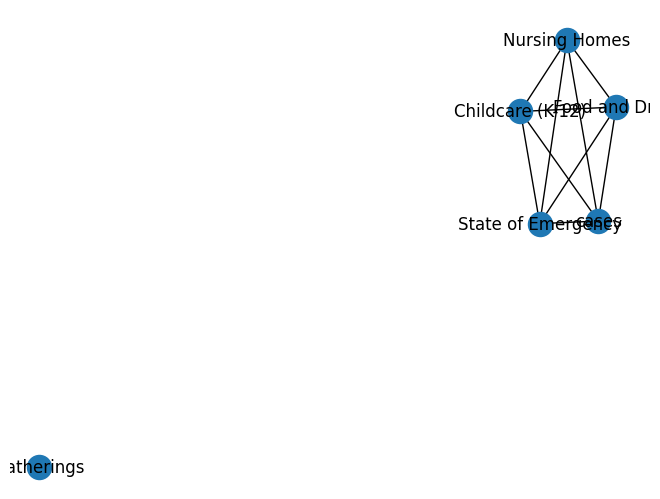

In [18]:
import matplotlib.pyplot as plt

plt.figure(1)
nx.draw(graph_covid_Mar26, with_labels=True)

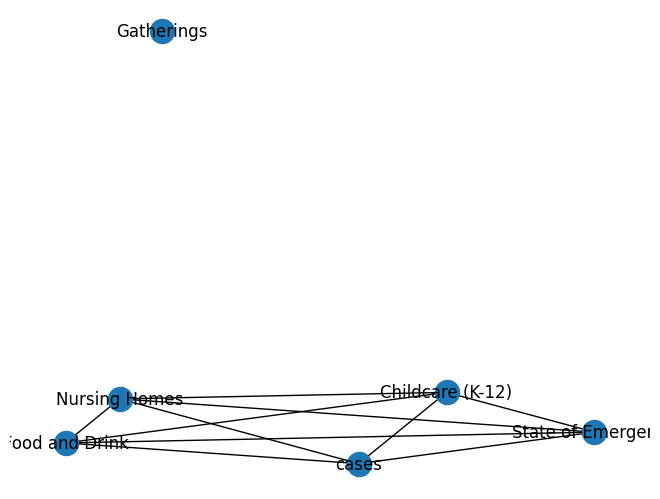

In [19]:
plt.figure(2)
nx.draw(graph_covid_May29, with_labels=True)

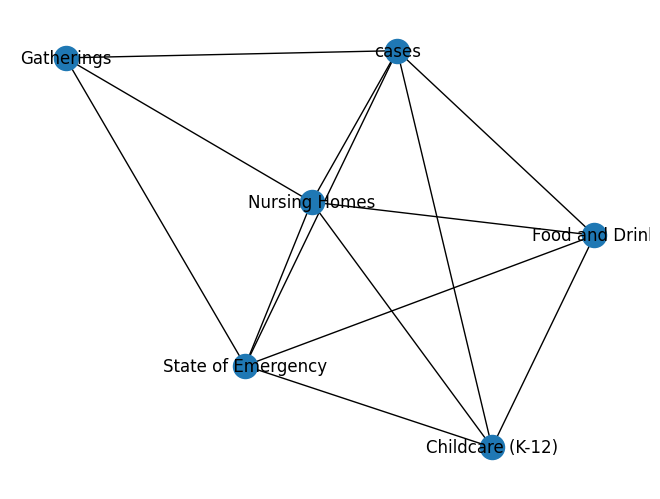

In [20]:
plt.figure(3)
nx.draw(graph_covid_Aug01, with_labels=True)

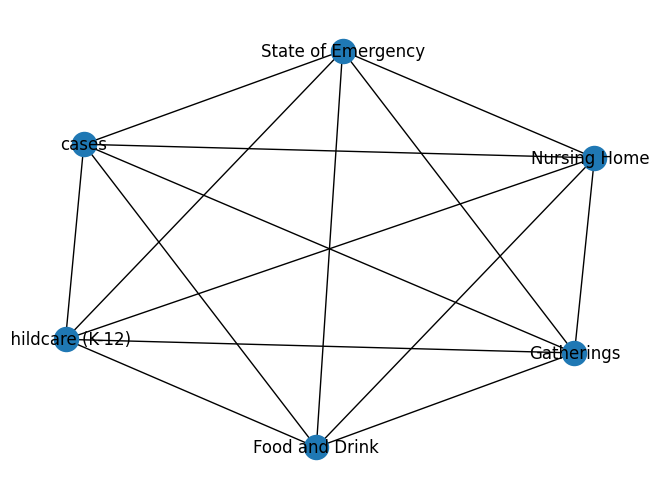

In [21]:
plt.figure(4)
nx.draw(graph_covid_Oct04, with_labels=True)

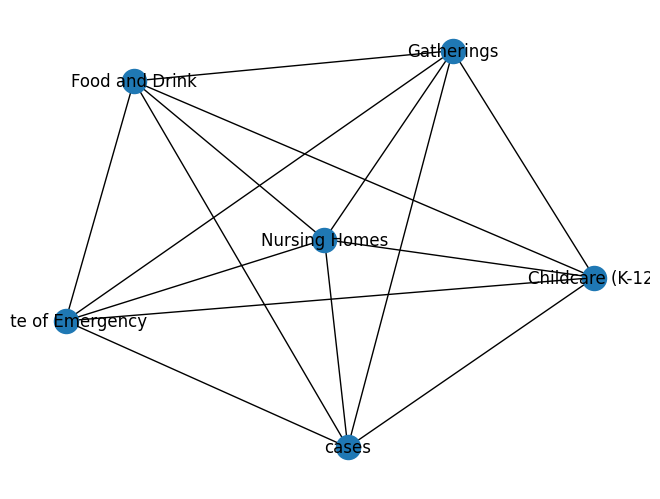

In [22]:
plt.figure(5)
nx.draw(graph_covid_Dec07, with_labels=True)

In [23]:
deaths_graph_covid_Mar26 = run_IC(deaths_df_Mar26, deaths_dct_covid)
# deaths_graph_covid_May29 = run_IC(deaths_df_May29, deaths_dct_covid)
deaths_graph_covid_Aug01 = run_IC(deaths_df_Aug01, deaths_dct_covid)
# deaths_graph_covid_Oct04 = run_IC(deaths_df_Oct04, deaths_dct_covid)
deaths_graph_covid_Dec07 = run_IC(deaths_df_Dec07, deaths_dct_covid)

/usr/local/lib/python3.10/dist-packages/statsmodels/robust/robust_linear_model.py:288: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  warnings.warn('Estimated scale is 0.0 indicating that the most'
/usr/local/lib/python3.10/dist-packages/statsmodels/robust/robust_linear_model.py:288: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  warnings.warn('Estimated scale is 0.0 indicating that the most'
/usr/local/lib/python3.10/dist-packages/statsmodels/robust/robust_linear_model.py:166: RuntimeWarning: invalid value encountered in divide
  return self.M(tmp_resid / tmp_results.scale).sum()
/usr/local/lib/python3.10/dist-packages/statsmodels/robust/robust_linear_model.py:288: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  warnings.warn('Estimated scal

3.9159696102142334
IC Algorithm successfully run


/usr/local/lib/python3.10/dist-packages/statsmodels/robust/robust_linear_model.py:288: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  warnings.warn('Estimated scale is 0.0 indicating that the most'
/usr/local/lib/python3.10/dist-packages/statsmodels/robust/robust_linear_model.py:288: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  warnings.warn('Estimated scale is 0.0 indicating that the most'
/usr/local/lib/python3.10/dist-packages/statsmodels/robust/robust_linear_model.py:288: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  warnings.warn('Estimated scale is 0.0 indicating that the most'
/usr/local/lib/python3.10/dist-packages/statsmodels/robust/robust_linear_model.py:288: ConvergenceWarning: Estimated scale is 0.0 indicating that the most la

214.55702114105225
IC Algorithm successfully run


/usr/local/lib/python3.10/dist-packages/statsmodels/robust/robust_linear_model.py:288: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  warnings.warn('Estimated scale is 0.0 indicating that the most'
/usr/local/lib/python3.10/dist-packages/statsmodels/robust/robust_linear_model.py:288: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  warnings.warn('Estimated scale is 0.0 indicating that the most'
/usr/local/lib/python3.10/dist-packages/statsmodels/robust/robust_linear_model.py:288: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  warnings.warn('Estimated scale is 0.0 indicating that the most'
/usr/local/lib/python3.10/dist-packages/statsmodels/robust/robust_linear_model.py:288: ConvergenceWarning: Estimated scale is 0.0 indicating that the most la

405.6298358440399
IC Algorithm successfully run


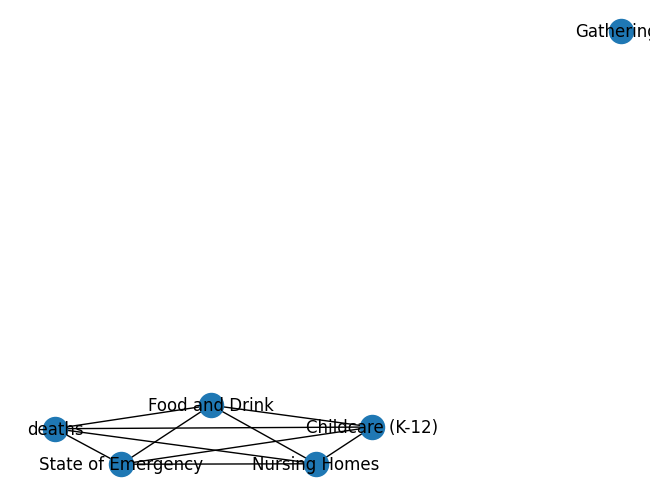

In [25]:
nx.draw(deaths_graph_covid_Mar26, with_labels=True)
# nx.draw(deaths_graph_covid_May29, with_labels=True)

In [ ]:
nx.draw(deaths_graph_covid_Aug01, with_labels=True)
# nx.draw(deaths_graph_covid_Oct04, with_labels=True)

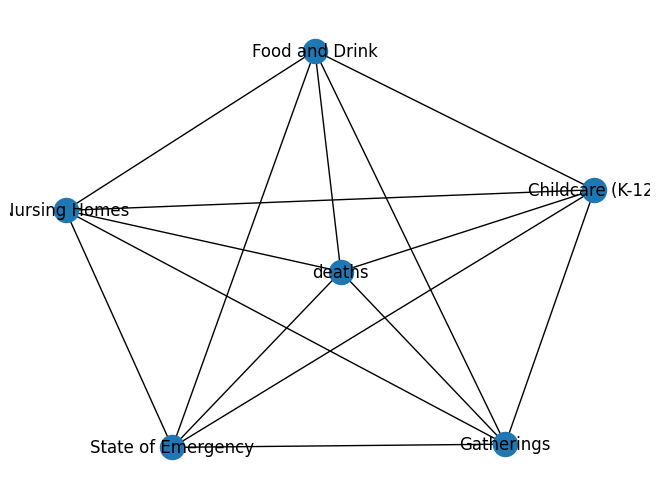

In [26]:
nx.draw(deaths_graph_covid_Dec07, with_labels=True)

## IC Algorithm to generate causal graphs for cases and deaths for Reopening set of Policies

In [50]:
import numpy
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import time
from causality.inference.search import IC
from causality.inference.independence_tests import RobustRegressionTest

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve, roc_curve, auc, average_precision_score
from sklearn.metrics import confusion_matrix

# Run the IC Search Algorithm
def run_IC(data_df, header_dct):

    # Check time Elapsed for IC Algorithm to run
    # Time in seconds
    start = time.time()

    # run the IC search
    ic_algorithm = IC(RobustRegressionTest)
    graph = ic_algorithm.search(data_df, header_dct)

    end = time.time()
    print(end - start)
    print("IC Algorithm successfully run")
    return graph


cases_dct_covid_reopening = {'Phase 2':'c', 'Entertainment':'c', 'Outdoor and Recreation':'c', 'Personal Care':'c', 'Food and Drink':'c', 'cases':'c'}
cases_columns_reopening = ['Phase 2', 'Entertainment', 'Outdoor and Recreation', 'Personal Care', 'Food and Drink', 'cases']

# Filter the DataFrame to include only the selected columns
covid_causal_df['date'] = pd.to_datetime(covid_causal_df['date'])

start_date = '01/01/2020'
end_date = '03/26/2020'
cases_df_Mar26_reop = covid_causal_df[(covid_causal_df['date'] >= start_date) & (covid_causal_df['date'] <= end_date)][cases_columns_reopening]

start_date = '03/26/2020'
end_date = '05/29/2020'
cases_df_May29_reop = covid_causal_df[(covid_causal_df['date'] >= start_date) & (covid_causal_df['date'] <= end_date)][cases_columns_reopening]

start_date = '01/01/2020'
end_date = '08/01/2020'
cases_df_Aug01_reop = covid_causal_df[(covid_causal_df['date'] >= start_date) & (covid_causal_df['date'] <= end_date)][cases_columns_reopening]

start_date = '01/01/2020'
end_date = '10/04/2020'
cases_df_Oct04_reop = covid_causal_df[(covid_causal_df['date'] >= start_date) & (covid_causal_df['date'] <= end_date)][cases_columns_reopening]

start_date = '01/01/2020'
end_date = '12/07/2020'
cases_df_Dec07_reop = covid_causal_df[(covid_causal_df['date'] >= start_date) & (covid_causal_df['date'] <= end_date)][cases_columns_reopening]

deaths_dct_covid_reopening = {'Phase 2':'c', 'Entertainment':'c', 'Outdoor and Recreation':'c', 'Personal Care':'c', 'Food and Drink':'c', 'deaths':'c'}
deaths_columns_reopening = ['Phase 2', 'Entertainment', 'Outdoor and Recreation', 'Personal Care', 'Food and Drink', 'deaths']

start_date = '01/01/2020'
end_date = '03/26/2020'
deaths_df_Mar26_reop = covid_causal_df[(covid_causal_df['date'] >= start_date) & (covid_causal_df['date'] <= end_date)][deaths_columns_reopening]

start_date = '01/01/2020'
end_date = '05/29/2020'
deaths_df_May29_reop = covid_causal_df[(covid_causal_df['date'] >= start_date) & (covid_causal_df['date'] <= end_date)][deaths_columns_reopening]

start_date = '01/01/2020'
end_date = '08/01/2020'
deaths_df_Aug01_reop = covid_causal_df[(covid_causal_df['date'] >= start_date) & (covid_causal_df['date'] <= end_date)][deaths_columns_reopening]

start_date = '01/01/2020'
end_date = '10/04/2020'
deaths_df_Oct04_reop = covid_causal_df[(covid_causal_df['date'] >= start_date) & (covid_causal_df['date'] <= end_date)][deaths_columns_reopening]

start_date = '01/01/2020'
end_date = '12/07/2020'
deaths_df_Dec07_reop = covid_causal_df[(covid_causal_df['date'] >= start_date) & (covid_causal_df['date'] <= end_date)][deaths_columns_reopening]

In [52]:
graph_covid_Mar26_reop = run_IC(cases_df_Mar26_reop, cases_dct_covid_reopening)
# graph_covid_May29 = run_IC(cases_df_May29, cases_dct_covid)
# graph_covid_Aug01 = run_IC(cases_df_Aug01, cases_dct_covid)
# graph_covid_Oct04 = run_IC(cases_df_Oct04, cases_dct_covid)
graph_covid_Dec07_reop = run_IC(cases_df_Dec07_reop, cases_dct_covid_reopening)

/usr/local/lib/python3.10/dist-packages/statsmodels/robust/robust_linear_model.py:288: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  warnings.warn('Estimated scale is 0.0 indicating that the most'
/usr/local/lib/python3.10/dist-packages/statsmodels/robust/robust_linear_model.py:288: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  warnings.warn('Estimated scale is 0.0 indicating that the most'
/usr/local/lib/python3.10/dist-packages/statsmodels/robust/robust_linear_model.py:288: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  warnings.warn('Estimated scale is 0.0 indicating that the most'
/usr/local/lib/python3.10/dist-packages/statsmodels/robust/robust_linear_model.py:288: ConvergenceWarning: Estimated scale is 0.0 indicating that the most la

7.373089075088501
IC Algorithm successfully run


/usr/local/lib/python3.10/dist-packages/statsmodels/robust/robust_linear_model.py:288: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  warnings.warn('Estimated scale is 0.0 indicating that the most'
/usr/local/lib/python3.10/dist-packages/statsmodels/robust/robust_linear_model.py:288: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  warnings.warn('Estimated scale is 0.0 indicating that the most'
/usr/local/lib/python3.10/dist-packages/statsmodels/robust/robust_linear_model.py:288: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  warnings.warn('Estimated scale is 0.0 indicating that the most'
/usr/local/lib/python3.10/dist-packages/statsmodels/robust/robust_linear_model.py:288: ConvergenceWarning: Estimated scale is 0.0 indicating that the most la

191.25669479370117
IC Algorithm successfully run


In [53]:
deaths_graph_covid_Mar26_reop = run_IC(deaths_df_Mar26_reop, deaths_dct_covid_reopening)
# deaths_graph_covid_May29 = run_IC(deaths_df_May29, deaths_dct_covid)
# deaths_graph_covid_Aug01 = run_IC(deaths_df_Aug01, deaths_dct_covid)
# deaths_graph_covid_Oct04 = run_IC(deaths_df_Oct04, deaths_dct_covid)
deaths_graph_covid_Dec07_reop = run_IC(deaths_df_Dec07_reop, deaths_dct_covid_reopening)

/usr/local/lib/python3.10/dist-packages/statsmodels/robust/robust_linear_model.py:288: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  warnings.warn('Estimated scale is 0.0 indicating that the most'
/usr/local/lib/python3.10/dist-packages/statsmodels/robust/robust_linear_model.py:288: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  warnings.warn('Estimated scale is 0.0 indicating that the most'
/usr/local/lib/python3.10/dist-packages/statsmodels/robust/robust_linear_model.py:288: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  warnings.warn('Estimated scale is 0.0 indicating that the most'
/usr/local/lib/python3.10/dist-packages/statsmodels/robust/robust_linear_model.py:288: ConvergenceWarning: Estimated scale is 0.0 indicating that the most la

7.751829385757446
IC Algorithm successfully run


/usr/local/lib/python3.10/dist-packages/statsmodels/robust/robust_linear_model.py:288: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  warnings.warn('Estimated scale is 0.0 indicating that the most'
/usr/local/lib/python3.10/dist-packages/statsmodels/robust/robust_linear_model.py:288: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  warnings.warn('Estimated scale is 0.0 indicating that the most'
/usr/local/lib/python3.10/dist-packages/statsmodels/robust/robust_linear_model.py:288: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  warnings.warn('Estimated scale is 0.0 indicating that the most'
/usr/local/lib/python3.10/dist-packages/statsmodels/robust/robust_linear_model.py:288: ConvergenceWarning: Estimated scale is 0.0 indicating that the most la

200.14818000793457
IC Algorithm successfully run


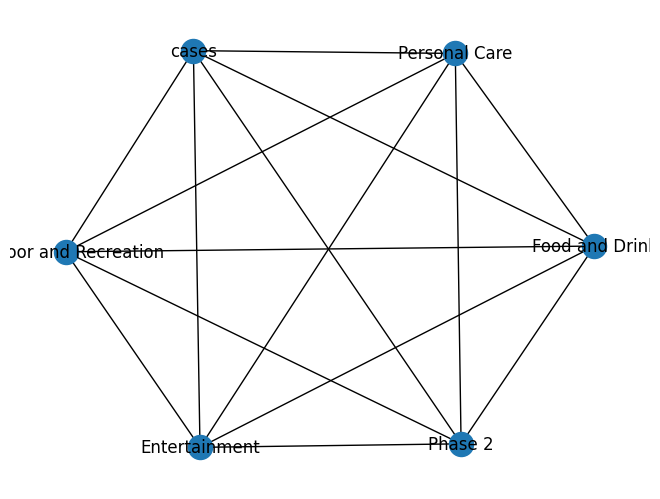

In [54]:
nx.draw(graph_covid_Mar26_reop, with_labels = True)

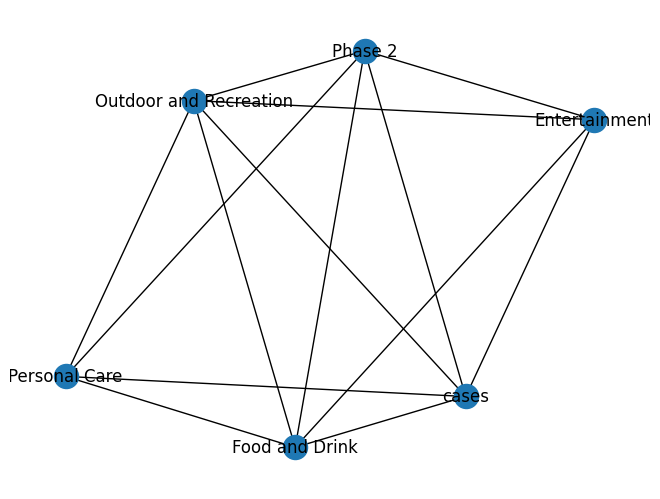

In [55]:
nx.draw(graph_covid_Dec07_reop, with_labels = True)

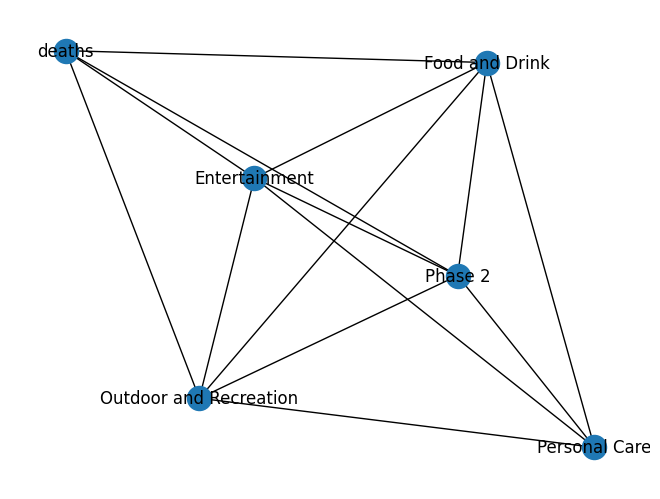

In [56]:
nx.draw(deaths_graph_covid_Mar26_reop, with_labels = True)

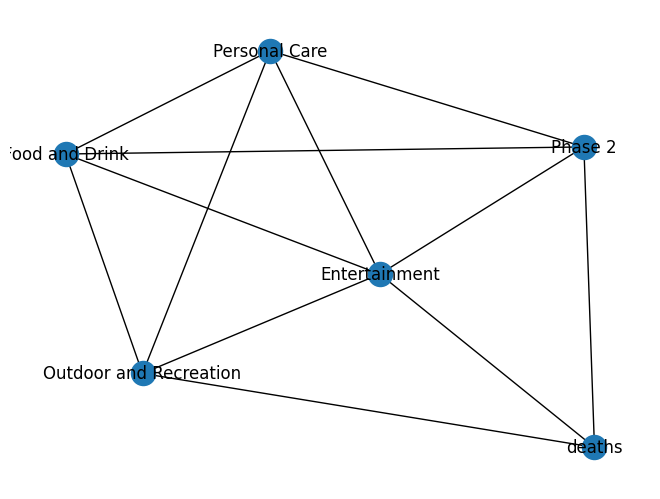

In [57]:
nx.draw(deaths_graph_covid_Dec07_reop, with_labels = True)

## IC Algorithm to generate causal graphs for cases and deaths for Mask Requirement set of Policies

In [58]:
import numpy
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import time
from causality.inference.search import IC
from causality.inference.independence_tests import RobustRegressionTest

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve, roc_curve, auc, average_precision_score
from sklearn.metrics import confusion_matrix

# Run the IC Search Algorithm
def run_IC(data_df, header_dct):

    # Check time Elapsed for IC Algorithm to run
    # Time in seconds
    start = time.time()

    # run the IC search
    ic_algorithm = IC(RobustRegressionTest)
    graph = ic_algorithm.search(data_df, header_dct)

    end = time.time()
    print(end - start)
    print("IC Algorithm successfully run")
    return graph


cases_dct_covid_mask = {'Mask Mandate':'c', 'Non-Essential Businesses':'c', 'Food and Drink':'c', 'Phase 3':'c', 'Phase 2':'c', 'cases':'c'}
cases_columns_mask = ['Mask Mandate', 'Non-Essential Businesses', 'Food and Drink', 'Phase 3', 'Phase 2', 'cases']

# Filter the DataFrame to include only the selected columns
covid_causal_df['date'] = pd.to_datetime(covid_causal_df['date'])

start_date = '01/01/2020'
end_date = '03/26/2020'
cases_df_Mar26_mask = covid_causal_df[(covid_causal_df['date'] >= start_date) & (covid_causal_df['date'] <= end_date)][cases_columns_mask]

start_date = '03/26/2020'
end_date = '05/29/2020'
cases_df_May29_mask = covid_causal_df[(covid_causal_df['date'] >= start_date) & (covid_causal_df['date'] <= end_date)][cases_columns_mask]

start_date = '01/01/2020'
end_date = '08/01/2020'
cases_df_Aug01_mask = covid_causal_df[(covid_causal_df['date'] >= start_date) & (covid_causal_df['date'] <= end_date)][cases_columns_mask]

start_date = '01/01/2020'
end_date = '10/04/2020'
cases_df_Oct04_mask = covid_causal_df[(covid_causal_df['date'] >= start_date) & (covid_causal_df['date'] <= end_date)][cases_columns_mask]

start_date = '01/01/2020'
end_date = '12/07/2020'
cases_df_Dec07_mask = covid_causal_df[(covid_causal_df['date'] >= start_date) & (covid_causal_df['date'] <= end_date)][cases_columns_mask]

deaths_dct_covid_mask = {'Mask Mandate':'c', 'Non-Essential Businesses':'c', 'Food and Drink':'c', 'Phase 3':'c', 'Phase 2':'c', 'deaths':'c'}
deaths_columns_mask = ['Mask Mandate', 'Non-Essential Businesses', 'Food and Drink', 'Phase 3', 'Phase 2', 'deaths']

start_date = '01/01/2020'
end_date = '03/26/2020'
deaths_df_Mar26_mask = covid_causal_df[(covid_causal_df['date'] >= start_date) & (covid_causal_df['date'] <= end_date)][deaths_columns_mask]

start_date = '01/01/2020'
end_date = '05/29/2020'
deaths_df_May29_mask = covid_causal_df[(covid_causal_df['date'] >= start_date) & (covid_causal_df['date'] <= end_date)][deaths_columns_mask]

start_date = '01/01/2020'
end_date = '08/01/2020'
deaths_df_Aug01_mask = covid_causal_df[(covid_causal_df['date'] >= start_date) & (covid_causal_df['date'] <= end_date)][deaths_columns_mask]

start_date = '01/01/2020'
end_date = '10/04/2020'
deaths_df_Oct04_mask = covid_causal_df[(covid_causal_df['date'] >= start_date) & (covid_causal_df['date'] <= end_date)][deaths_columns_mask]

start_date = '01/01/2020'
end_date = '12/07/2020'
deaths_df_Dec07_mask = covid_causal_df[(covid_causal_df['date'] >= start_date) & (covid_causal_df['date'] <= end_date)][deaths_columns_mask]

In [44]:
graph_covid_Mar26_mask = run_IC(cases_df_Mar26_mask, cases_dct_covid_mask)
# graph_covid_May29_mask = run_IC(cases_df_May29_mask, cases_dct_covid_mask)
# graph_covid_Aug01_mask = run_IC(cases_df_Aug01_mask, cases_dct_covid_mask)
# graph_covid_Oct04_mask = run_IC(cases_df_Oct04_mask, cases_dct_covid_mask)
graph_covid_Dec07_mask = run_IC(cases_df_Dec07_mask, cases_dct_covid_mask)

/usr/local/lib/python3.10/dist-packages/statsmodels/robust/robust_linear_model.py:288: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  warnings.warn('Estimated scale is 0.0 indicating that the most'
/usr/local/lib/python3.10/dist-packages/statsmodels/robust/robust_linear_model.py:288: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  warnings.warn('Estimated scale is 0.0 indicating that the most'
/usr/local/lib/python3.10/dist-packages/statsmodels/robust/robust_linear_model.py:288: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  warnings.warn('Estimated scale is 0.0 indicating that the most'
/usr/local/lib/python3.10/dist-packages/statsmodels/robust/robust_linear_model.py:288: ConvergenceWarning: Estimated scale is 0.0 indicating that the most la

11.557996273040771
IC Algorithm successfully run


/usr/local/lib/python3.10/dist-packages/statsmodels/robust/robust_linear_model.py:288: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  warnings.warn('Estimated scale is 0.0 indicating that the most'
/usr/local/lib/python3.10/dist-packages/statsmodels/robust/robust_linear_model.py:288: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  warnings.warn('Estimated scale is 0.0 indicating that the most'
/usr/local/lib/python3.10/dist-packages/statsmodels/robust/robust_linear_model.py:288: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  warnings.warn('Estimated scale is 0.0 indicating that the most'
/usr/local/lib/python3.10/dist-packages/statsmodels/robust/robust_linear_model.py:288: ConvergenceWarning: Estimated scale is 0.0 indicating that the most la

225.0951008796692
IC Algorithm successfully run


In [59]:
deaths_graph_covid_Mar26_mask = run_IC(deaths_df_Mar26_mask, deaths_dct_covid_mask)
# deaths_graph_covid_May29_mask = run_IC(deaths_df_May29_mask, deaths_dct_covid_mask)
# deaths_graph_covid_Aug01_mask = run_IC(deaths_df_Aug01_mask, deaths_dct_covid_mask)
# deaths_graph_covid_Oct04_mask = run_IC(deaths_df_Oct04_mask, deaths_dct_covid_mask)
deaths_graph_covid_Dec07_mask = run_IC(deaths_df_Dec07_mask, deaths_dct_covid_mask)

/usr/local/lib/python3.10/dist-packages/statsmodels/robust/robust_linear_model.py:288: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  warnings.warn('Estimated scale is 0.0 indicating that the most'
/usr/local/lib/python3.10/dist-packages/statsmodels/robust/robust_linear_model.py:288: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  warnings.warn('Estimated scale is 0.0 indicating that the most'
/usr/local/lib/python3.10/dist-packages/statsmodels/robust/robust_linear_model.py:288: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  warnings.warn('Estimated scale is 0.0 indicating that the most'
/usr/local/lib/python3.10/dist-packages/statsmodels/robust/robust_linear_model.py:288: ConvergenceWarning: Estimated scale is 0.0 indicating that the most la

9.790387392044067
IC Algorithm successfully run


/usr/local/lib/python3.10/dist-packages/statsmodels/robust/robust_linear_model.py:288: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  warnings.warn('Estimated scale is 0.0 indicating that the most'
/usr/local/lib/python3.10/dist-packages/statsmodels/robust/robust_linear_model.py:288: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  warnings.warn('Estimated scale is 0.0 indicating that the most'
/usr/local/lib/python3.10/dist-packages/statsmodels/robust/robust_linear_model.py:288: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  warnings.warn('Estimated scale is 0.0 indicating that the most'
/usr/local/lib/python3.10/dist-packages/statsmodels/robust/robust_linear_model.py:288: ConvergenceWarning: Estimated scale is 0.0 indicating that the most la

230.36674451828003
IC Algorithm successfully run


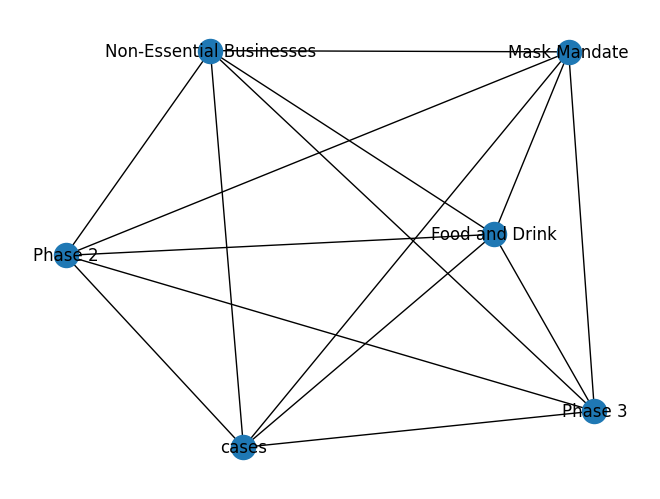

In [60]:
nx.draw(graph_covid_Mar26_mask, with_labels = True)

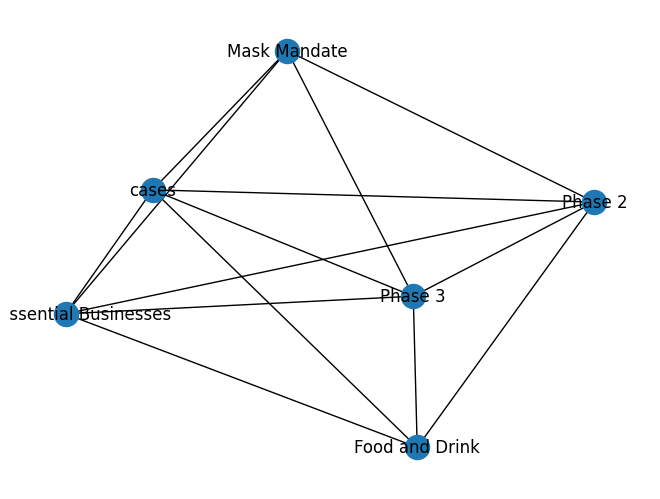

In [61]:
nx.draw(graph_covid_Dec07_mask, with_labels = True)

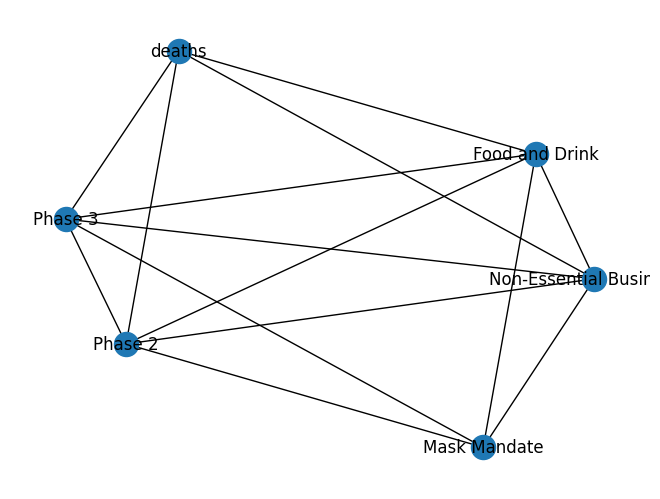

In [62]:
nx.draw(deaths_graph_covid_Mar26_mask, with_labels = True)

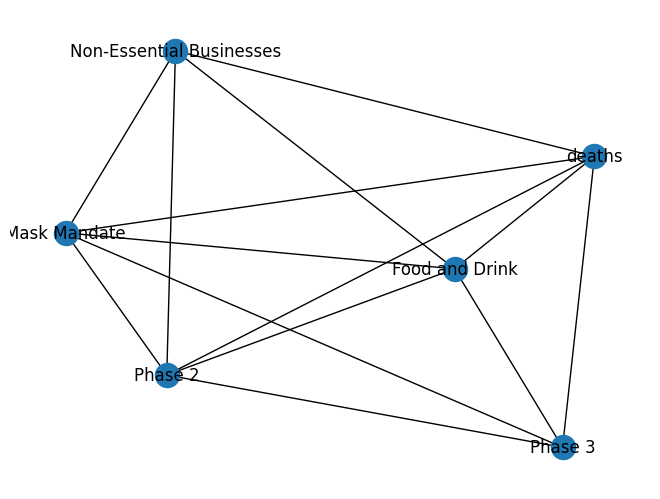

In [63]:
nx.draw(deaths_graph_covid_Dec07_mask, with_labels = True)

# PCA-CMI method of building a causal graph for the COVID-19 data

In [64]:
!pip install pycm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.3/70.3 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 599.8/599.8 kB 12.5 MB/s eta 0:00:00


In [65]:
import time
import os
import numpy as np
import pandas as pd
import argparse
import matplotlib.pyplot as plt
from copy import deepcopy
from scipy import interpolate
from sklearn.feature_selection import mutual_info_regression
from scipy.stats import pearsonr
import scipy.sparse
import sys
import pickle
import re
from scipy import stats
from numpy import savetxt
from numpy import genfromtxt
import networkx as nx
from scipy.stats import norm
import itertools
import math
import copy
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, roc_curve, auc, average_precision_score
from sklearn.metrics import confusion_matrix
from pycm import *

In [66]:
def safe_division(a, b):
    if b != 0:
        result = a / b
        return result
    else:
        print("Error: Division by zero!")
        return 1



def conditional_mutual_info(X,Y,Z=np.array(1)):

    if X.ndim == 1:
            X = np.reshape(X, (-1, 1))

    if Y.ndim == 1:
            Y = np.reshape(Y, (-1, 1))

    if Z.ndim == 0:
        c1 = np.cov(X)

        if c1.ndim != 0:
            d1 = np.linalg.det(c1)
        else:
            d1 = c1.item()

        c2 = np.cov(Y)

        if c2.ndim != 0:
            d2 = np.linalg.det(c2)
        else:
            d2 = c2.item()

        c3 = np.cov(X,Y)

        if c3.ndim != 0:
            d3 = np.linalg.det(c3)
        else:
            d3 = c3.item()

        cmi = (1/2)*np.log(safe_division((d1*d2), d3))

    else:

        if Z.ndim == 1:
            Z = np.reshape(Z, (-1, 1))

        c1 = np.cov(np.concatenate((X, Z), axis=0))

        if c1.ndim != 0:
            d1 = np.linalg.det(c1)
        else:
            d1 = c1.item()

        c2 = np.cov(np.concatenate((Y, Z), axis=0))

        if c2.ndim != 0:
            d2 = np.linalg.det(c2)
        else:
            d2 = c2.item()

        c3 = np.cov(Z)

        if c3.ndim != 0:
            d3 = np.linalg.det(c3)
        else:
            d3 = c3.item()

        c4 = np.cov(np.concatenate((X, Y, Z), axis=0))

        if c4.ndim != 0:
            d4 = np.linalg.det(c4)
        else:
            d4 = c4.item()

        cmi = (1/2)*np.log(safe_division((d1*d2), (d3*d4)))


    if math.isinf(cmi):
        cmi = 0

    return cmi


In [67]:
def pca_cmi(data, theta, max_order):

    genes = list(data.columns)

    predicted_graph = nx.complete_graph(genes)
    num_edges = predicted_graph.number_of_edges()
    print("Number of edges in the initial complete graph : {}".format(num_edges))
    print()

    L = -1
    nochange = False

    while L < max_order and nochange == False:
        L = L+1
        predicted_graph, nochange = remove_edges(predicted_graph, data, L, theta)

        print("Order : {}".format(L))
        print("Number of edges in the predicted graph : {}".format(predicted_graph.number_of_edges()))
        print()


    print()
    print()
    print("Final Prediction:")
    print("-----------------")
    print("Order : {}".format(L))
    print("Number of edges in the predicted graph : {}".format(predicted_graph.number_of_edges()))
    nx.draw(predicted_graph, with_labels=True, font_weight='bold')
    print()
    return predicted_graph


def remove_edges(predicted_graph, data, L, theta):

    initial_num_edges = predicted_graph.number_of_edges()

    edges = predicted_graph.edges()

    for edge in edges:
        neighbors = nx.common_neighbors(predicted_graph, edge[0], edge[1])
        nhbrs = copy.deepcopy(sorted(neighbors))\

        T = len(nhbrs)

        if T < L and L != 0:
            continue

        else:
            x = data[edge[0]].to_numpy()
            if x.ndim == 1:
                x = np.reshape(x, (-1, 1))

            y = data[edge[1]].to_numpy()
            if y.ndim == 1:
                y = np.reshape(y, (-1, 1))

            K = list(itertools.combinations(nhbrs, L))

            if L == 0:
                cmiVal = conditional_mutual_info(x.T, y.T)

                if cmiVal < theta:
                    predicted_graph.remove_edge(edge[0], edge[1])

            else:

                maxCmiVal = 0

                for zgroup in K:

                    z = data[list(zgroup)].to_numpy()
                    if z.ndim == 1:
                        z = np.reshape(z, (-1, 1))

                    cmiVal = conditional_mutual_info(x.T, y.T, z.T)

                    if cmiVal > maxCmiVal:
                        maxCmiVal = cmiVal

                if maxCmiVal < theta:
                    predicted_graph.remove_edge(edge[0], edge[1])



    final_num_edges = predicted_graph.number_of_edges()

    if final_num_edges < initial_num_edges:
        return  predicted_graph, False


    return  predicted_graph, True


Number of edges in the initial complete graph : 15

Error: Division by zero!
Error: Division by zero!
Error: Division by zero!
Error: Division by zero!
Error: Division by zero!
Order : 0
Number of edges in the predicted graph : 4

Order : 1
Number of edges in the predicted graph : 4



Final Prediction:
-----------------
Order : 1
Number of edges in the predicted graph : 4



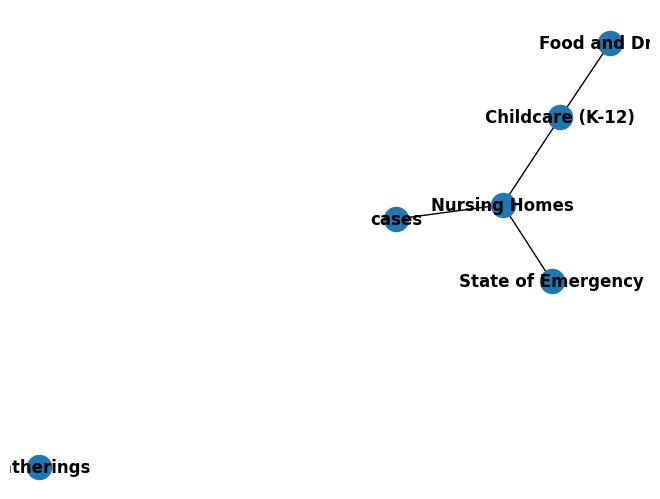

In [68]:
graph_cases_Mar26 = pca_cmi(cases_df_Mar26, 0.005, 20)

Number of edges in the initial complete graph : 15

Order : 0
Number of edges in the predicted graph : 8

Order : 1
Number of edges in the predicted graph : 7

Order : 2
Number of edges in the predicted graph : 7



Final Prediction:
-----------------
Order : 2
Number of edges in the predicted graph : 7



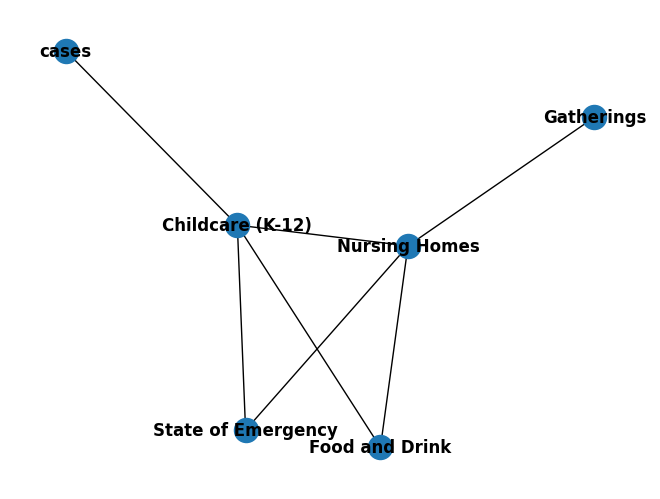

In [69]:
graph_cases_Dec07 = pca_cmi(cases_df_Dec07, 0.005, 20)

Number of edges in the initial complete graph : 15

Error: Division by zero!
Error: Division by zero!
Error: Division by zero!
Error: Division by zero!
Error: Division by zero!
Order : 0
Number of edges in the predicted graph : 4

Order : 1
Number of edges in the predicted graph : 4



Final Prediction:
-----------------
Order : 1
Number of edges in the predicted graph : 4



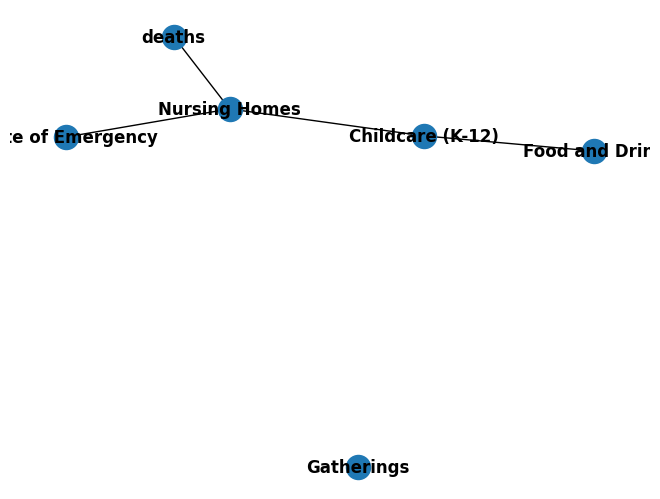

In [70]:
graph_deaths_Dec07 = pca_cmi(deaths_df_Mar26, 0.005, 20)

Number of edges in the initial complete graph : 15

Order : 0
Number of edges in the predicted graph : 10

Order : 1
Number of edges in the predicted graph : 8

Order : 2
Number of edges in the predicted graph : 8



Final Prediction:
-----------------
Order : 2
Number of edges in the predicted graph : 8



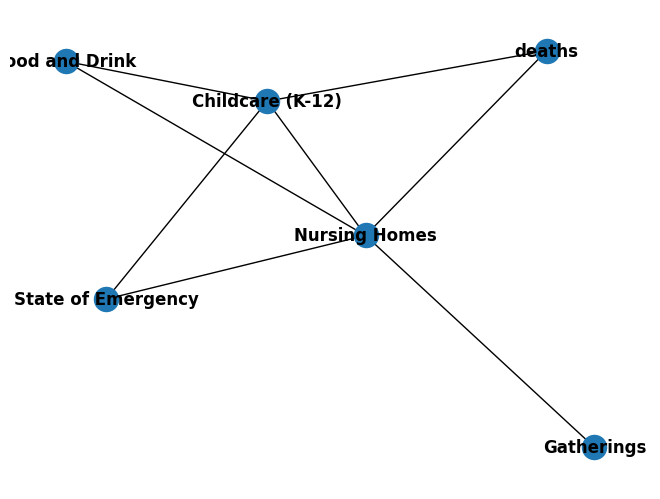

In [71]:
graph_deaths_Dec07 = pca_cmi(deaths_df_Dec07, 0.005, 20)

Number of edges in the initial complete graph : 15

Order : 0
Number of edges in the predicted graph : 9

Order : 1
Number of edges in the predicted graph : 8

Order : 2
Number of edges in the predicted graph : 6

Order : 3
Number of edges in the predicted graph : 6



Final Prediction:
-----------------
Order : 3
Number of edges in the predicted graph : 6



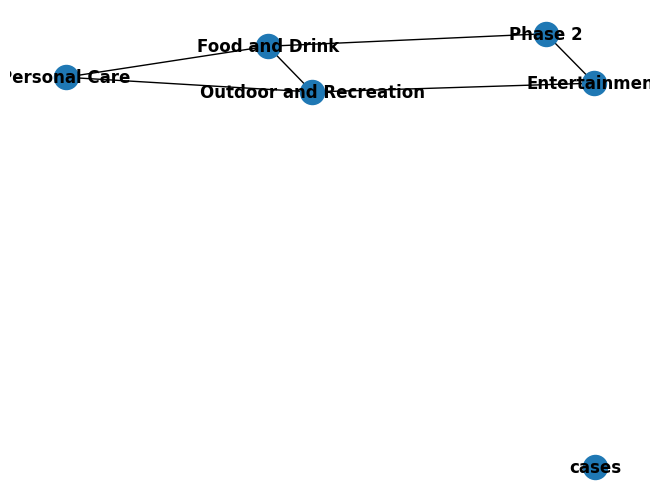

In [85]:
graph_cases_Mar26_reop = pca_cmi(cases_df_Mar26_reop, 0.005, 20)

Number of edges in the initial complete graph : 15

Order : 0
Number of edges in the predicted graph : 13

Order : 1
Number of edges in the predicted graph : 11

Order : 2
Number of edges in the predicted graph : 11



Final Prediction:
-----------------
Order : 2
Number of edges in the predicted graph : 11



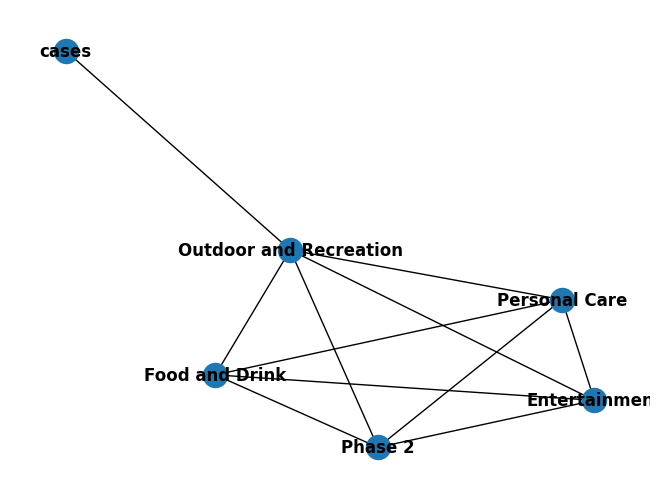

In [79]:
graph_cases_Dec07_reop = pca_cmi(cases_df_Dec07_reop, 0.005, 20)

Number of edges in the initial complete graph : 15

Order : 0
Number of edges in the predicted graph : 9

Order : 1
Number of edges in the predicted graph : 8

Order : 2
Number of edges in the predicted graph : 6

Order : 3
Number of edges in the predicted graph : 6



Final Prediction:
-----------------
Order : 3
Number of edges in the predicted graph : 6



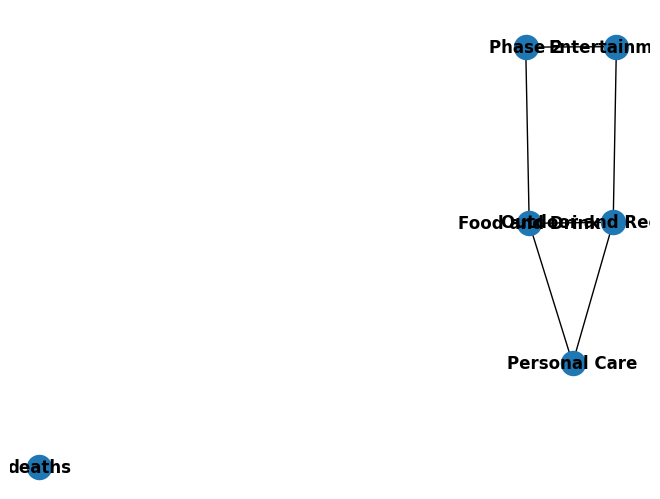

In [82]:
graph_deaths_Mar26_reop = pca_cmi(deaths_df_Mar26_reop, 0.005, 20)

Number of edges in the initial complete graph : 15

Order : 0
Number of edges in the predicted graph : 13

Order : 1
Number of edges in the predicted graph : 11

Order : 2
Number of edges in the predicted graph : 11



Final Prediction:
-----------------
Order : 2
Number of edges in the predicted graph : 11



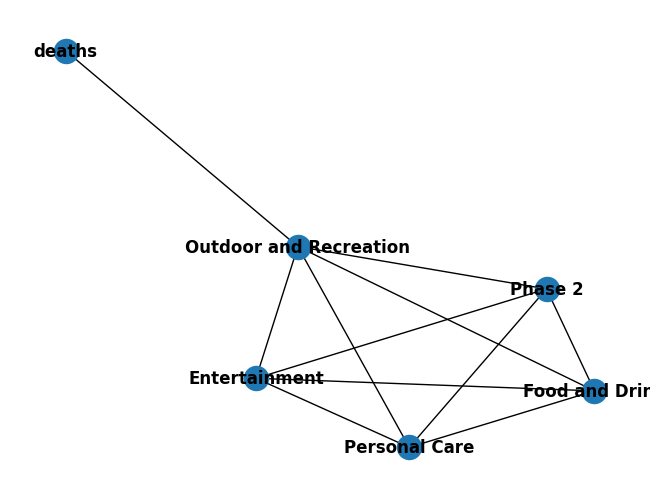

In [83]:
graph_deaths_Dec07_reop = pca_cmi(deaths_df_Dec07_reop, 0.005, 20)

Number of edges in the initial complete graph : 15

Order : 0
Number of edges in the predicted graph : 6

Order : 1
Number of edges in the predicted graph : 6



Final Prediction:
-----------------
Order : 1
Number of edges in the predicted graph : 6



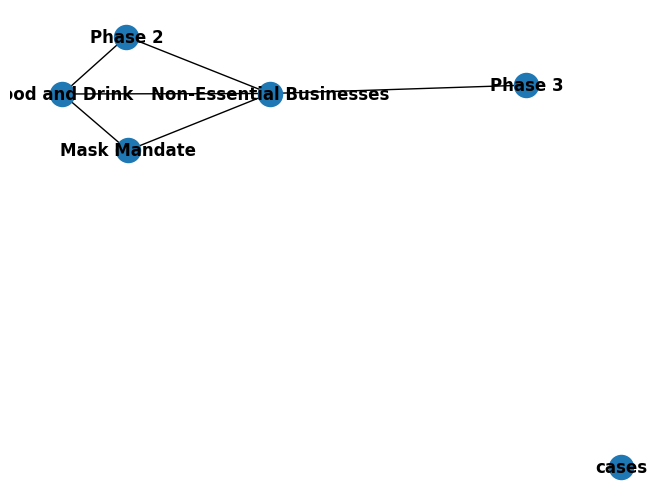

In [86]:
graph_cases_Mar26_mask = pca_cmi(cases_df_Mar26_mask, 0.005, 20)

Number of edges in the initial complete graph : 15

Order : 0
Number of edges in the predicted graph : 13

Order : 1
Number of edges in the predicted graph : 11

Order : 2
Number of edges in the predicted graph : 11



Final Prediction:
-----------------
Order : 2
Number of edges in the predicted graph : 11



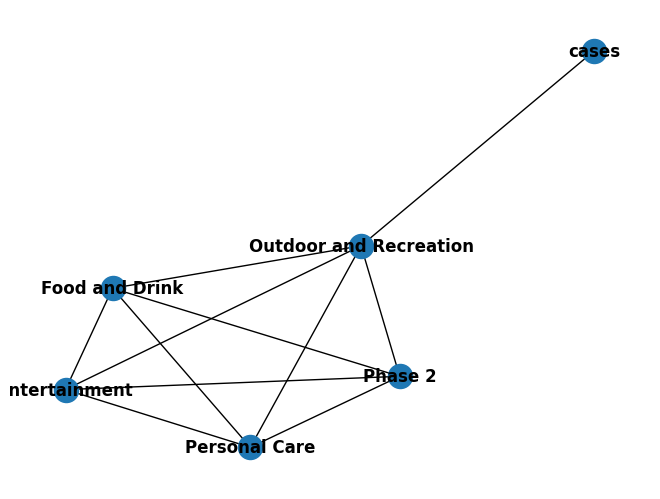

In [87]:
graph_cases_Dec07_reop = pca_cmi(cases_df_Dec07_reop, 0.005, 20)

Number of edges in the initial complete graph : 15

Order : 0
Number of edges in the predicted graph : 9

Order : 1
Number of edges in the predicted graph : 8

Order : 2
Number of edges in the predicted graph : 6

Order : 3
Number of edges in the predicted graph : 6



Final Prediction:
-----------------
Order : 3
Number of edges in the predicted graph : 6



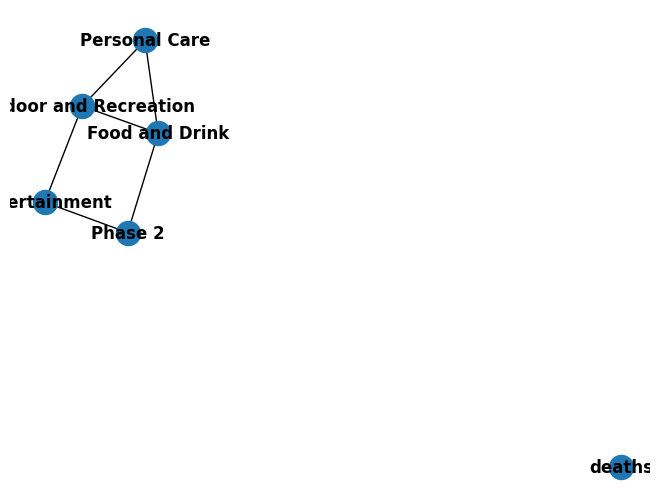

In [88]:
graph_deaths_Mar26_reop = pca_cmi(deaths_df_Mar26_reop, 0.005, 20)

Number of edges in the initial complete graph : 15

Order : 0
Number of edges in the predicted graph : 13

Order : 1
Number of edges in the predicted graph : 11

Order : 2
Number of edges in the predicted graph : 11



Final Prediction:
-----------------
Order : 2
Number of edges in the predicted graph : 11



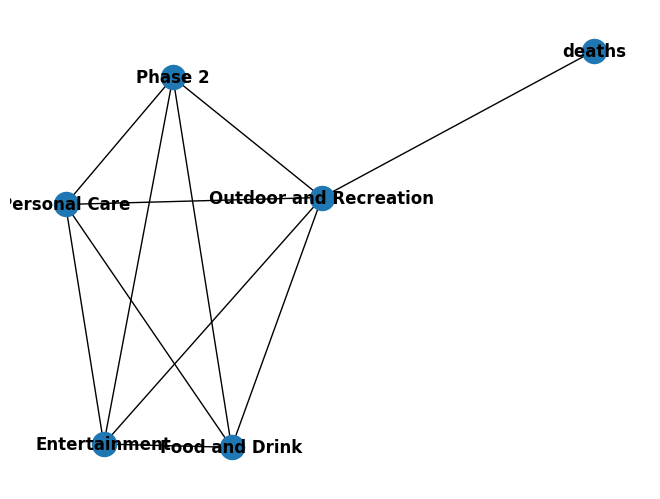

In [89]:
graph_deaths_Dec07_reop = pca_cmi(deaths_df_Dec07_reop, 0.005, 20)